In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "huydaoquang" # username from the json file
os.environ['KAGGLE_KEY'] = "0eb162199ef4cf635c9586a2d18aaf2f" # key from the json file

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:31<00:00, 25.9MB/s]
100% 2.29G/2.29G [00:31<00:00, 77.7MB/s]


In [0]:
import zipfile
file = zipfile.ZipFile('/content/chest-xray-pneumonia.zip')
file.extractall()

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm_notebook
import time
import random
import numpy as np

In [0]:
import os
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ColorJitter, RandomHorizontalFlip, RandomRotation, Resize, Normalize,ToTensor
from torch.optim import lr_scheduler

In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
batch_size= 32
epoch = 5
lr = 0.001
clip = 5

In [0]:
class ChestXrayDataset(Dataset):

  def __init__(self,folder_dir,n_classes,augmentation=None):
      super(ChestXrayDataset,self).__init__()
      self.folder_dir = folder_dir
      self.augmentation = augmentation
      self.n_classes = n_classes

      self.normal_dir = os.path.join(self.folder_dir,'NORMAL')
      self.pneumonia_dir = os.path.join(self.folder_dir,'PNEUMONIA')

      self.normal_image_names = os.listdir(self.normal_dir)
      self.pneumonia_image_names = os.listdir(self.pneumonia_dir)

      self.normal_image_paths = [os.path.join(self.normal_dir,x) for x in self.normal_image_names]
      self.pneumonia_image_paths = [os.path.join(self.pneumonia_dir,x) for x in self.pneumonia_image_names]

      self.normal_classes = [1] * len(self.normal_image_paths)
      self.pneumonia_classes = [0]* len(self.pneumonia_image_paths)

      self.data = list(zip(self.normal_image_paths,self.normal_classes))
      self.data.extend(list(zip(self.pneumonia_image_paths,self.pneumonia_classes)))

      random.shuffle(self.data)

      print(self.data[0])
  
  def __len__(self):
      return len(self.data)
  
  def __read_image(self,image_path):
      image = Image.open(image_path)
      image = image.convert('RGB')
      return image
  
  def __getitem__(self, idx):
      image_path , label = self.data[idx]
      image = self.__read_image(image_path)
      if self.augmentation:
          image = self.augmentation(image)
      return np.array(image), np.array(label)

In [0]:
pytorch_augmentation = Compose([
    Resize((300,300)),
    ColorJitter(hue=.05, saturation=.05),
    RandomHorizontalFlip(),
    RandomRotation(20),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_pytorch_augmentation = Compose([
    Resize((300,300)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [0]:
train_dataset = ChestXrayDataset(folder_dir='/content/chest_xray/train',
                            n_classes=2,
                            augmentation = pytorch_augmentation
                            )

('/content/chest_xray/train/PNEUMONIA/person1056_bacteria_2990.jpeg', 0)


In [0]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

In [0]:
from torchvision.models.resnet import resnet101

In [0]:
model = resnet101(pretrained=True)

In [0]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [0]:
layer_names = ['conv1','bn1','layer1','layer2','layer3','layer4']
model.conv1.requires_grad = False
model.bn1.requires_grad = False
model.layer1.requires_grad = False
model.layer2.requires_grad = False
model.layer3.requires_grad = False
model.layer4.requires_grad = False

In [0]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [0]:
del train_dataset
del val_dataset
del train_loader
del val_loader

NameError: ignored

In [0]:
train_dataset = ChestXrayDataset(folder_dir='/content/chest_xray/train',
                            n_classes=2,
                            augmentation = pytorch_augmentation
                            )
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)
val_dataset = ChestXrayDataset(folder_dir='/content/chest_xray/test',
                            n_classes=2,
                            augmentation = val_pytorch_augmentation
                            )

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=0)

('/content/chest_xray/train/PNEUMONIA/person1425_virus_2438.jpeg', 0)
('/content/chest_xray/test/NORMAL/IM-0010-0001.jpeg', 1)


In [0]:
def get_mean(lis):

  return sum(lis)/len(lis)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
def train(model,optimizer,criterion,epoch):
    model.cuda()
    for i in range(epoch):
        train_loss_epoch = []
        val_loss_epoch = []

        model.train()

        for batch in tqdm_notebook(train_loader):

            model.zero_grad()
            image_tensor, label = batch
            image_tensor = image_tensor.cuda()
            label = label.cuda()

            logit = model(image_tensor)

            loss = criterion(logit,label)

            train_loss_epoch.append(loss.item())

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
        print('----------Evaluate-----------')
        model.eval()
        with torch.no_grad():
            pred_list = []
            target_list = []

            for batch in tqdm_notebook(val_loader):

                  image_tensor, label = batch

                  image_tensor = image_tensor.cuda()
                  label = label.cuda()

                  logit = model(image_tensor)

                  loss = criterion(logit,label)

                  val_loss_epoch.append(loss.item())

                  pred_classes = torch.argmax(logit,dim=-1).cpu().data.numpy().tolist()
                  pred_list.extend(pred_classes)

                  target_classes = label.cpu().data.numpy().tolist()
                  target_list.extend(target_classes)

        print('Epoch: {0}, train_loss:{1:.2f}, val_loss:{2:.2f}'.format(i+1,get_mean(train_loss_epoch),get_mean(val_loss_epoch)))
        print(classification_report(target_list,pred_list,target_names=['PNEUMONIA','NORMAL']))
              

In [0]:
## Warm up training
train(model,optimizer,criterion,epoch)


----------Evaluate-----------



Epoch: 1, train_loss:0.22, val_loss:1.39
              precision    recall  f1-score   support

   PNEUMONIA       0.63      0.99      0.77       390
      NORMAL       0.50      0.01      0.03       234

    accuracy                           0.62       624
   macro avg       0.56      0.50      0.40       624
weighted avg       0.58      0.62      0.49       624




----------Evaluate-----------



Epoch: 2, train_loss:0.16, val_loss:1.30
              precision    recall  f1-score   support

   PNEUMONIA       0.65      1.00      0.78       390
      NORMAL       1.00      0.09      0.16       234

    accuracy                           0.66       624
   macro avg       0.82      0.54      0.47       624
weighted avg       0.78      0.66      0.55       624




----------Evaluate-----------



Epoch: 3, train_loss:0.13, val_loss:0.91
              precision    recall  f1-score   support

   PNEUMONIA       0.73      0.99      0.84       390
      NORMAL       0.98      0.38      0.55       234

    accuracy                           0.77       624
   macro avg       0.85      0.69      0.70       624
weighted avg       0.82      0.77      0.73       624




----------Evaluate-----------



Epoch: 4, train_loss:0.10, val_loss:0.74
              precision    recall  f1-score   support

   PNEUMONIA       0.75      0.98      0.85       390
      NORMAL       0.95      0.47      0.62       234

    accuracy                           0.79       624
   macro avg       0.85      0.73      0.74       624
weighted avg       0.83      0.79      0.77       624




----------Evaluate-----------



Epoch: 5, train_loss:0.12, val_loss:1.06
              precision    recall  f1-score   support

   PNEUMONIA       0.71      1.00      0.83       390
      NORMAL       0.99      0.32      0.48       234

    accuracy                           0.74       624
   macro avg       0.85      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



In [0]:
#unfreeze all layers
model.conv1.requires_grad = True
model.bn1.requires_grad = True
model.layer1.requires_grad = True
model.layer2.requires_grad = True
model.layer3.requires_grad = True
model.layer4.requires_grad = True

In [0]:
train(model,optimizer,criterion,epoch)


----------Evaluate-----------



Epoch: 1, train_loss:0.10, val_loss:0.98
              precision    recall  f1-score   support

   PNEUMONIA       0.71      1.00      0.83       390
      NORMAL       0.99      0.32      0.48       234

    accuracy                           0.74       624
   macro avg       0.85      0.66      0.65       624
weighted avg       0.81      0.74      0.70       624




----------Evaluate-----------



Epoch: 2, train_loss:0.09, val_loss:0.80
              precision    recall  f1-score   support

   PNEUMONIA       0.75      0.99      0.85       390
      NORMAL       0.97      0.44      0.61       234

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624




----------Evaluate-----------



Epoch: 3, train_loss:0.09, val_loss:0.31
              precision    recall  f1-score   support

   PNEUMONIA       0.91      0.91      0.91       390
      NORMAL       0.85      0.85      0.85       234

    accuracy                           0.89       624
   macro avg       0.88      0.88      0.88       624
weighted avg       0.89      0.89      0.89       624




----------Evaluate-----------



Epoch: 4, train_loss:0.09, val_loss:1.39
              precision    recall  f1-score   support

   PNEUMONIA       0.68      1.00      0.81       390
      NORMAL       0.98      0.22      0.36       234

    accuracy                           0.71       624
   macro avg       0.83      0.61      0.58       624
weighted avg       0.79      0.71      0.64       624




----------Evaluate-----------



Epoch: 5, train_loss:0.09, val_loss:0.62
              precision    recall  f1-score   support

   PNEUMONIA       0.78      0.99      0.87       390
      NORMAL       0.98      0.54      0.69       234

    accuracy                           0.82       624
   macro avg       0.88      0.77      0.78       624
weighted avg       0.85      0.82      0.81       624



In [0]:
torch.save(model,'82_acc_99_recall_valid.pth')

In [0]:
import seaborn as sn
import pandas as pd

In [0]:
def eval(model,test_path):
    test_dataset = val_dataset = ChestXrayDataset(folder_dir=test_path,
                            n_classes=2,
                            augmentation=val_pytorch_augmentation
                            )

    test_loader = DataLoader(dataset=test_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=0)
    model.eval()
    with torch.no_grad():
        pred_list = []
        target_list = []

        for batch in tqdm_notebook(test_loader):

              image_tensor, label = batch

              image_tensor = image_tensor.cuda()
              label = label.cuda()

              logit = model(image_tensor)

              pred_classes = torch.argmax(logit,dim=-1).cpu().data.numpy().tolist()
              pred_list.extend(pred_classes)

              target_classes = label.cpu().data.numpy().tolist()
              target_list.extend(target_classes)

    cm = confusion_matrix(target_list,pred_list)

    print(cm)

    df_cm = pd.DataFrame(cm.astype(np.uint32), index = [i for i in ['PNEUMONIA','NORMAL']],
                  columns = [i for i in ['PNEUMONIA','NORMAL']])
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='d')

    plt.title('Confusion Matrix')

    plt.show()

    print(classification_report(target_list,pred_list,target_names=['PNEUMONIA','NORMAL']))

In [0]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [0]:
model = torch.load('/content/82_acc_99_recall_valid.pth')

In [0]:
test_path = '/content/chest_xray/test'

('/content/chest_xray/test/NORMAL/NORMAL2-IM-0341-0001.jpeg', 1)



[[387   3]
 [108 126]]


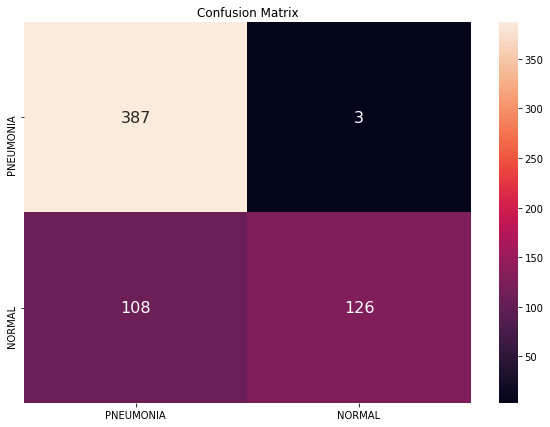

              precision    recall  f1-score   support

   PNEUMONIA       0.78      0.99      0.87       390
      NORMAL       0.98      0.54      0.69       234

    accuracy                           0.82       624
   macro avg       0.88      0.77      0.78       624
weighted avg       0.85      0.82      0.81       624



In [75]:
eval(model,test_path)

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp /content/gdrive/My\ Drive/82_acc_99_recall_valid.pth -r /content/82_acc_99_recall_valid.pth 